# 230614_causal_tracing_visualisation
{dt}\_omcd_{ds}.json, {dt}\_tmod_{ds}.json loading하고 visualisation 하기 위한 노트북


# Import libraries

In [1]:
from transformers import GPT2LMHeadModel, GPT2TokenizerFast, GPT2Tokenizer, set_seed
from datasets import load_dataset
from tqdm import tqdm
import json
import torch
import argparse
import datasets
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pylab as plt
from os import listdir

/rds/general/user/jj1122/home/anaconda3/envs/m2d2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Config

In [2]:
torch.manual_seed(718)
set_seed(718)

In [3]:
# ROME
# - localisation: pre-trained LM을 대상으로 지식 정보가 담겨있는 모듈을 찾아냄
# - ROME: 해당 부분에 적합한 

# 내가 만들고 싶은 model editing은 fine-tuning을 대체할 수 있는 방법이었음

In [4]:
list_models = [
#     "cs_l1",
#     "nlin_l1",
#     "Health_and_fitness",
#     "Natural_and_physical_sciences",
#     "Religion_and_belief_systems",
#     "Culture_and_the_arts",
#     "General_referece",
    "econ_l1",
#     "History_and_events",
#     "Human_activites",
#     "Mathematics_and_logic",
# #     "astro-ph_l1",
# #     "cond-mat_l1",
#     "eess_l1",
# #     "math_l1",
# #     "physics_l1 (ERROR)",
#     "q-bio_l1",
#     "q-fin_l1",
#     "stat_l1",
#     "Philosophy",
#     "Philosophy_and_thinking",
#     "Society_and_social_sciences",
#     "Technology_and_applied_sciences",
]
# len(list_models), len(set(list_models))

In [5]:
dataset_nm = list_models[0]
# dataset_path = f"../m2d2/dataset/{dataset_nm}/train.txt"
cache_dir="/rds/general/user/jj1122/ephemeral/.cache/huggingface"

In [6]:
device_id = 'cpu'
# tuned_model_path = f"/rds/general/user/jj1122/home/projects/m2d2/dataset/{dataset_nm}/models"
n_layers = 12
list_modules = ['attn', 'mlp']
trace_module_id = "transformer.h.{l}.{m}"

In [7]:
output_dir = "/rds/general/user/jj1122/home/projects/m2d2/utils/output_logs/"

In [8]:
list_trace_module_ids = []

for l in range(n_layers):
    for m in list_modules:
        list_trace_module_ids.append(trace_module_id.format(l=l, m=m))

print(list_trace_module_ids[:3])

['transformer.h.0.attn', 'transformer.h.0.mlp', 'transformer.h.1.attn']


In [9]:
def get_json_path(dir_path, job_cd):
    l_dir = listdir(dir_path)
    dt = max([x.split("_")[0] for x in l_dir if job_cd in x])
    return dir_path + f"{dt}_{job_cd}.json"

# OMCD

In [10]:
job_cd = f"omcd_{dataset_nm}"

In [11]:
with open(get_json_path(output_dir, job_cd), "r") as json_file:
    omcd = json.load(json_file)
get_json_path(output_dir, job_cd)

'/rds/general/user/jj1122/home/projects/m2d2/utils/output_logs/230624_omcd_econ_l1.json'

In [12]:
omcd[5000]

{'clean_loss': 9.606649004885389,
 'corrupted_loss': 13.049214888045217,
 'restored_loss': {'transformer.h.0.attn': 10.096801253158114,
  'transformer.h.0.mlp': 11.607725700445368,
  'transformer.h.1.attn': 16.53244859580643,
  'transformer.h.1.mlp': 48.915638019943025,
  'transformer.h.2.attn': 11.948290308315624,
  'transformer.h.2.mlp': 12.320097835431625,
  'transformer.h.3.attn': 12.442908066656887,
  'transformer.h.3.mlp': 10.467200167893132,
  'transformer.h.4.attn': 13.222219227319277,
  'transformer.h.4.mlp': 12.350663465749813,
  'transformer.h.5.attn': 11.852744593827968,
  'transformer.h.5.mlp': 12.320326950099187,
  'transformer.h.6.attn': 11.685034671486452,
  'transformer.h.6.mlp': 12.627006443068655,
  'transformer.h.7.attn': 12.001250615913376,
  'transformer.h.7.mlp': 12.37450554182634,
  'transformer.h.8.attn': 12.551656246562002,
  'transformer.h.8.mlp': 10.943333679434359,
  'transformer.h.9.attn': 11.847023498092666,
  'transformer.h.9.mlp': 11.910019698448009,
  

In [13]:
list_df_temp = list(range(len(omcd)))

for i, d in enumerate(omcd):
#     print(i)
    TE = (d["corrupted_loss"] - d["clean_loss"]) / d["clean_loss"]
    IE = {}
    for m_id in list_trace_module_ids:
        IE[m_id] = (d["restored_loss"][m_id] - d["clean_loss"]) / d["clean_loss"]
    list_df_temp[i] = pd.DataFrame.from_dict(IE, orient="index").reset_index()
    list_df_temp[i].columns = ["code", "IE"]
    list_df_temp[i]["TE"] = TE
    list_df_temp[i]["clean_loss"] = d["clean_loss"]
    list_df_temp[i]["corrupted_loss"] = d["corrupted_loss"]
    list_df_temp[i]["restored_loss"] = list(d["restored_loss"].values())
    list_df_temp[i]["sent_id"] = i
    del TE, IE


In [14]:
omcd[5002]

{'clean_loss': 27.827308442067025,
 'corrupted_loss': 140.87757282243842,
 'restored_loss': {'transformer.h.0.attn': 34.476418677200904,
  'transformer.h.0.mlp': 29.37763075965806,
  'transformer.h.1.attn': 123.0649411087044,
  'transformer.h.1.mlp': 79.37217706129343,
  'transformer.h.2.attn': 102.61629123529467,
  'transformer.h.2.mlp': 72.91651989462308,
  'transformer.h.3.attn': 100.86965470523452,
  'transformer.h.3.mlp': 101.09115017384312,
  'transformer.h.4.attn': 95.16548584889892,
  'transformer.h.4.mlp': 81.1298090834099,
  'transformer.h.5.attn': 97.17187738765452,
  'transformer.h.5.mlp': 213.02858390748224,
  'transformer.h.6.attn': 84.87464988596346,
  'transformer.h.6.mlp': 103.06096058057292,
  'transformer.h.7.attn': 93.97231534195983,
  'transformer.h.7.mlp': 83.56982790405058,
  'transformer.h.8.attn': 92.15859327817208,
  'transformer.h.8.mlp': 87.47170624839183,
  'transformer.h.9.attn': 101.55642228900977,
  'transformer.h.9.mlp': 84.01272576800608,
  'transforme

In [15]:
def parse_code(row):
    list_code = row.code.split(".")
    row['l'] = int(list_code[2])
    row['m'] = list_code[3]
#     row['t'] = int(list_code[4])
    return row

In [16]:
df_omcd = pd.concat(list_df_temp, axis=0, ignore_index=True).reset_index(drop=True)
# df_omcd = df_omcd.apply(lambda row: parse_code(row), axis=1)

In [17]:

df_omcd["list_code"] = df_omcd["code"].apply(lambda code: code.split("."))
df_omcd["l"] = df_omcd["list_code"].apply(lambda l: int(l[2]))
df_omcd["m"] = df_omcd["list_code"].apply(lambda l: l[3])

In [18]:
del omcd, list_df_temp, df_omcd["list_code"]

In [19]:
df_omcd = df_omcd.rename({"IE": "omcd_IE"}, axis=1)
df_omcd_ie = df_omcd.groupby(["l", "m"]).agg({"omcd_IE": ['mean', 'std']})

# tmod

In [20]:
job_cd = f"tmod_{dataset_nm}"

In [21]:
with open(get_json_path(output_dir, job_cd), "r") as json_file:
    tmod = json.load(json_file)
get_json_path(output_dir, job_cd)

'/rds/general/user/jj1122/home/projects/m2d2/utils/output_logs/230627_tmod_econ_l1.json'

In [22]:
list_df_temp = list(range(len(tmod)))

for i, d in enumerate(tmod):
    TE = (d["corrupted_loss"] - d["clean_loss"]) / d["clean_loss"]
    IE = {}
    for m_id in list_trace_module_ids:
        IE[m_id] = (d["restored_loss"][m_id] - d["clean_loss"]) / d["clean_loss"]
    list_df_temp[i] = pd.DataFrame.from_dict(IE, orient="index").reset_index()
    list_df_temp[i].columns = ["code", "IE"]
    list_df_temp[i]["TE"] = TE
    list_df_temp[i]["clean_loss"] = d["clean_loss"]
    list_df_temp[i]["corrupted_loss"] = d["corrupted_loss"]
    list_df_temp[i]["restored_loss"] = list(d["restored_loss"].values())
    list_df_temp[i]["sent_id"] = i
    del TE, IE


In [23]:
df_tmod = pd.concat(list_df_temp, axis=0, ignore_index=True).reset_index(drop=True)

In [24]:
df_tmod["list_code"] = df_tmod["code"].apply(lambda code: code.split("."))
df_tmod["l"] = df_tmod["list_code"].apply(lambda l: int(l[2]))
df_tmod["m"] = df_tmod["list_code"].apply(lambda l: l[3])

In [25]:
del tmod, list_df_temp, df_tmod["list_code"]

In [26]:
df_tmod = df_tmod.rename({"IE": "tmod_IE"}, axis=1)

In [27]:
df_tmod_ie = df_tmod.groupby(["l", "m"]).agg({"tmod_IE": ['mean', 'std']})

## Visualisation

In [28]:
df_tmod_ie.unstack(-1)

tmod_IE                              
        mean                 std          
m       attn       mlp      attn       mlp
l                                         
0   2.596232  2.241391  5.002927  3.808259
1   2.729091  2.620212  5.470792  5.438404
2   2.942899  2.467333  6.477697  4.835054
3   2.846573  2.535872  6.544505  5.881089
4   2.828730  2.556809  6.454928  4.998028
5   2.779391  2.411849  6.346486  4.851334
6   2.749847  2.309956  6.291502  4.631292
7   2.660074  2.101164  6.068424  3.813747
8   2.662988  1.918132  6.025850  3.359917
9   2.716406  1.817307  6.424118  3.078375
10  2.726520  1.858763  6.350793  3.259076
11  2.850842  2.338023  6.387064  3.996299

In [29]:
df_omcd_ie.unstack(-1)

omcd_IE                              
        mean                 std          
m       attn       mlp      attn       mlp
l                                         
0   0.359047  0.058125  0.442029  0.084256
1   2.989029  2.408109  3.427487  3.709924
2   2.463498  1.876507  4.093031  2.059568
3   2.247659  1.712601  3.771080  1.791527
4   2.296415  1.724588  3.454904  1.727021
5   1.960788  2.584607  2.938638  2.908851
6   1.925964  2.396549  3.040526  2.686030
7   1.737966  1.918331  3.104494  1.963694
8   1.907174  1.694374  3.281666  1.674025
9   2.018796  1.569262  3.217344  1.574654
10  2.181782  1.631805  3.654496  1.689695
11  2.426785  2.506455  3.365925  2.629557

In [30]:
df_omcd.loc[(df_omcd["l"] == 0) & (df_omcd["m"] == "attn")]

,code,omcd_IE,TE,clean_loss,corrupted_loss,restored_loss,sent_id,l,m
0,transformer.h.0.attn,0.205455,3.065850,24.447821,99.401182,29.470737,0,0,attn
24,transformer.h.0.attn,0.346638,4.484085,33.725719,184.954693,45.416318,1,0,attn
48,transformer.h.0.attn,0.363871,10.979901,11.963204,143.318003,16.316268,2,0,attn
72,transformer.h.0.attn,0.608681,7.578590,15.502882,132.992868,24.939189,3,0,attn
96,transformer.h.0.attn,0.038286,0.776935,20.832525,37.018049,21.630123,4,0,attn
...,...,...,...,...,...,...,...,...,...
349296,transformer.h.0.attn,0.050742,0.691646,21.892721,37.034725,23.003603,14554,0,attn
349320,transformer.h.0.attn,0.231943,3.061203,13.929048,56.568693,17.159790,14555,0,attn
349344,transformer.h.0.attn,0.180187,0.438961,14.547698,20.933567,17.169010,14556,0,attn
349368,transformer.h.0.attn,0.964715,6.660107,18.302065,140.195783,35.958338,14557,0,attn


### Mean

<Axes: xlabel='l', ylabel='None-None-m'>

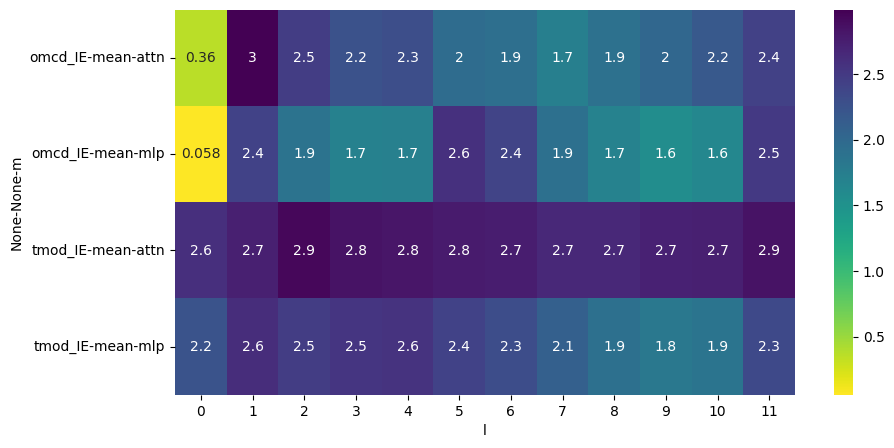

In [31]:
plt.rcParams["figure.figsize"] = (10,5)

sns.heatmap(
    pd.concat(
        [df_omcd_ie.drop([("omcd_IE", "std")], axis=1).unstack(-1).T, 
         df_tmod_ie.drop([("tmod_IE", "std")], axis=1).unstack(-1).T],
        axis=0#, ignore_index=True
    ),
    cmap = 'viridis_r', annot=True
)

In [32]:
df_omcd["TE"].mean(), df_tmod["TE"].mean()

(3.3904595559429067, 3.0319837091771245)

### STD

<Axes: xlabel='l', ylabel='None-None-m'>

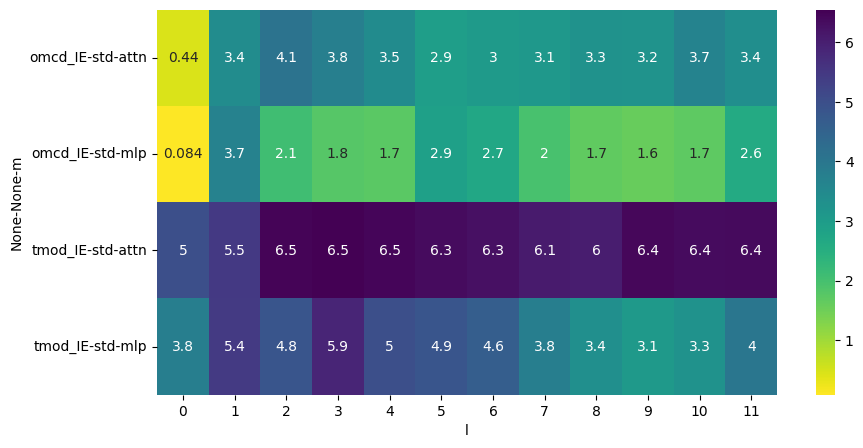

In [33]:
plt.rcParams["figure.figsize"] = (10,5)

sns.heatmap(
    pd.concat(
        [df_omcd_ie.drop([("omcd_IE", "mean")], axis=1).unstack(-1).T, 
         df_tmod_ie.drop([("tmod_IE", "mean")], axis=1).unstack(-1).T],
        axis=0#, ignore_index=True
    ),
    cmap = 'viridis_r', annot=True
)

In [192]:
df_tmod_ie

tmod_IE          
             mean       std
l  m                       
0  attn  1.392550  4.755750
   mlp   1.239698  5.352454
1  attn  1.392361  5.056961
   mlp   1.347994  5.546974
2  attn  1.379095  5.367181
   mlp   0.969292  4.091656
3  attn  1.425283  5.418646
   mlp   1.328863  4.971496
4  attn  1.412697  5.753466
   mlp   1.275896  4.335904
5  attn  1.421866  5.498844
   mlp   1.208429  4.135693
6  attn  1.382109  5.340853
   mlp   1.141260  4.321564
7  attn  1.365664  5.306649
   mlp   0.992000  3.205233
8  attn  1.363969  5.716667
   mlp   0.890063  3.271982
9  attn  1.353166  5.365762
   mlp   0.906373  3.711678
10 attn  1.374312  5.537928
   mlp   0.756289  2.345117
11 attn  1.755053  6.847063
   mlp   1.213411  3.752539

In [193]:
df_omcd_ie

omcd_IE          
             mean       std
l  m                       
0  attn  0.000000  0.000000
   mlp   0.254446  0.880258
1  attn  1.509759  6.338639
   mlp   1.088170  5.017040
2  attn  0.805924  5.049498
   mlp   0.895984  3.699546
3  attn  0.806140  4.403909
   mlp   0.765413  7.922298
4  attn  0.861360  6.070074
   mlp   0.769589  2.782282
5  attn  0.820727  3.976727
   mlp   0.734714  3.754888
6  attn  0.802472  4.274798
   mlp   0.686684  2.627810
7  attn  0.850917  6.900412
   mlp   0.633919  1.725676
8  attn  0.907005  8.791721
   mlp   0.662103  2.859513
9  attn  0.874409  4.616572
   mlp   0.624362  3.218762
10 attn  0.948723  6.384575
   mlp   0.637038  5.260665
11 attn  0.897728  4.863683
   mlp   0.794367  4.932191

# Model

## load models

In [23]:
base_model = GPT2LMHeadModel.from_pretrained("gpt2", cache_dir=cache_dir).to(device_id)
gpt2_tokenizer = GPT2Tokenizer.from_pretrained(tuned_model_path)
tuned_model = GPT2LMHeadModel.from_pretrained(tuned_model_path).to(device_id)

In [ ]:
# base_model = GPT2LMHeadModel.from_pretrained("gpt2").to(device_id)
# tuned_model = GPT2LMHeadModel.from_pretrained(tuned_model_path).to(device_id)

In [ ]:
# diff_weights = {}
# for tuned_tup, base_tup in zip(list(tuned_model.named_parameters()), list(base_model.named_parameters())):
#     diff_weights[tuned_tup[0]] = torch.abs(tuned_tup[1] - base_tup[1]).mean().item()
    
# diff_weights

# Data

In [22]:
dataset = load_dataset("machelreid/m2d2", dataset_nm, cache_dir=cache_dir)

Found cached dataset m2d2 (/rds/general/user/jj1122/ephemeral/.cache/huggingface/machelreid___m2d2/Religion_and_belief_systems/0.0.0/eb235f33a5de3163c10549b7f63c906910539c8a8c0ec5ade1285ccbf5067d00)
100%|██████████| 3/3 [00:00<00:00, 229.65it/s]


In [ ]:
# np.random.seed(718)

# x = 10 * np.random.randint(100000)

# dataset['train']['text'][x:x+10]

In [ ]:
# # input_text = "He was a religious scholar and a prolific writer. Many of his works are used as references for church members"

# # input_text = "In popular and media culture, Anubis is often falsely portrayed as the sinister god of the dead"

# # input_text = "Ankou appears as a man or skeleton wearing a black robe and a large hat which conceals his face, or, on occasion, simply as a shadow"

# # input_text = "Zechariah's vision of recently deceased Joshua the High Priest depicts a dispute in the heavenly throne room between Satan and the Angel of the Lord"

# input_text = "The Transcendental Argument for the Existence of God (TAG) is the argument that attempts to prove the existence of God by arguing that logic, morals, and science ultimately presuppose a supreme being and that God must therefore be the source of logic and morals"


In [24]:
list_test_data = [x for x in dataset['test']['text'].copy() if x!=''] 

In [25]:
def load_model():
    return GPT2LMHeadModel.from_pretrained(tuned_model_path).to(device_id)

In [26]:
def save_clean_activation(m_id):
    def save_clean_activation_hook(module, _input, _output):
#         print(m_id, _output.shape)
        if m_id.endswith('attn'):
            clean_activations[m_id] = _output[0].detach()
        elif m_id.endswith('mlp'):
#         else:
            clean_activations[m_id] = _output.detach()
    return save_clean_activation_hook


def corrupt_input_vector(module, _input):#, _output):
    torch.manual_seed(718)
    std = torch.std(_input[0])
    return tuple([_input[0] + (std*1.5) * torch.randn(_input[0].shape).to(device_id), ])

def restore_activation(m_id):
    def restore_activation_hook(module, _input, _output):
        clean_activation = clean_activations[m_id]#[:, t]
        if m_id.endswith('attn'):
#             corrupted_activation = _output[0].detach()
#             base_output[:, t] = tuned_output
#             corrupted_activation = clean_activation
            return tuple([clean_activation, tuple([_output[1][0], _output[1][1]])])
        elif m_id.endswith('mlp'):           
            base_output = _output.detach()
#             base_output[:, t] = tuned_output
            base_output = clean_activation
            return base_output
    return restore_activation_hook

In [ ]:
def restore_activation(m_id):
    def restore_activation_hook(module, _input, _output):
        clean_activation = clean_activations[m_id]
        if m_id.endswith('attn'):
            return tuple([clean_activation, tuple([_output[1][0], _output[1][1]])])
        elif m_id.endswith('mlp'):           
            base_output = _output.detach()
            base_output = clean_activation
            return base_output
    return restore_activation_hook

In [27]:
def corrupt_input_vector(module, _input):#, _output):
    torch.manual_seed(718)
    std = torch.std(_input[0])
    return tuple([_input[0] + (std*1.5) * torch.randn(_input[0].shape).to(device_id), ])

In [28]:
def restore_activation(m_id):
    def restore_activation_hook(module, _input, _output):
        clean_activation = clean_activations[m_id]#[:, t]
        if m_id.endswith('attn'):
#             corrupted_activation = _output[0].detach()
#             base_output[:, t] = tuned_output
#             corrupted_activation = clean_activation
            return tuple([clean_activation, tuple([_output[1][0], _output[1][1]])])
        elif m_id.endswith('mlp'):           
            base_output = _output.detach()
#             base_output[:, t] = tuned_output
            base_output = clean_activation
            return base_output
    return restore_activation_hook

## 10:45

In [30]:
list_results = [{} for x in range(len(list_test_data)) if x != ""]

for input_idx, input_text in enumerate(list_test_data):
    
    if input_idx % 1000 == 0:
        print(f"input_idx: {input_idx}")
    
    inputs = gpt2_tokenizer(input_text, return_tensors="pt").to(device_id)
    n_tokens = inputs['input_ids'].shape[1]
    
    list_input_text = gpt2_tokenizer.convert_ids_to_tokens(inputs['input_ids'][0].cpu().numpy())

    for idx in range(1, n_tokens):
        if not list_input_text[idx].startswith("Ġ"):
            list_input_text[idx-1] = list_input_text[idx-1] + "##"
        list_input_text[idx] = list_input_text[idx].replace("Ġ", "")
        
    # First run: clean run
    clean_activations = {}
    tuned_model = load_model()
    for m_id in list_trace_module_ids:
        tuned_model.get_submodule(m_id).register_forward_hook(save_clean_activation(m_id))
        
    with torch.no_grad():
        tuned_model.eval()
        clean_outputs = tuned_model(**inputs, labels=inputs.input_ids, output_hidden_states=True)    
        clean_loss = np.exp(clean_outputs.loss.item())
    
    # Second run: corrupted run    
    tuned_model = load_model()
    tuned_model.get_submodule("transformer.h.0.attn").register_forward_pre_hook(corrupt_input_vector)    
    with torch.no_grad():
        torch.manual_seed(718)
        set_seed(718)
        tuned_model.eval()
        corrupted_outputs = tuned_model(**inputs, labels=inputs.input_ids, output_hidden_states=True)
        corrupted_loss = np.exp(corrupted_outputs.loss.item())
        
    corrupted_loss    

    # Third run: corrupted-with-restoration run    
    restored_loss = {}
    tuned_model = GPT2LMHeadModel.from_pretrained(tuned_model_path).to(device_id)

    with torch.no_grad():
        tuned_model.eval()
        tuned_model.get_submodule("transformer.h.0.attn").register_forward_pre_hook(corrupt_input_vector)
        for m_id in list_trace_module_ids:
            hook = tuned_model.get_submodule(m_id).register_forward_hook(restore_activation(m_id))
            restored_outputs = tuned_model(**inputs, labels=inputs.input_ids, output_hidden_states=True)
            restored_loss[m_id] = np.exp(restored_outputs.loss.item())
            hook.remove()
            
    list_results[input_idx]['clean_loss'] = clean_loss
    list_results[input_idx]['corrupted_loss'] = corrupted_loss
    list_results[input_idx]['restored_loss'] = restored_loss

input_idx: 0
input_idx: 1000
input_idx: 2000
input_idx: 3000


KeyboardInterrupt: 

In [32]:
import pickle as pkl
with open('230607_run_outputs.pkl', 'wb') as pkl_file:
    pkl.dump(list_results, pkl_file)

In [34]:
for i, d in enumerate(list_results):
    if len(d) == 0:
        print(i)
        break

3040


In [36]:
list_results_temp = list_results[:3000]

# Main

## first run - clean

### register hook - save_clean_activation

### get clean_activations & clean_loss

13.573352837326823

## second run - corruped

### register hook - corrupt_input_vector

### get corrupt_input_vector & corrupted_loss

18.395775714257592

## Thrid run - corrupted-with-restoration run

### register hook - restore_activation & restored losses

In [643]:
list(restored_loss.items())[:10]

[('transformer.h.0.attn', 13.573352837326823),
 ('transformer.h.0.mlp', 14.274880534457854),
 ('transformer.h.1.attn', 21.543103091989984),
 ('transformer.h.1.mlp', 20.8595076933879),
 ('transformer.h.2.attn', 17.51346675330437),
 ('transformer.h.2.mlp', 18.091306491554267),
 ('transformer.h.3.attn', 16.443810897114936),
 ('transformer.h.3.mlp', 16.982345444060076),
 ('transformer.h.4.attn', 17.352509155673943),
 ('transformer.h.4.mlp', 18.33990111156065)]

## Losses

In [37]:
list_results_temp[0]

{'clean_loss': 63.91878399603464,
 'corrupted_loss': 132.82606231021126,
 'restored_loss': {'transformer.h.0.attn': 63.91878399603464,
  'transformer.h.0.mlp': 72.45914462107228,
  'transformer.h.1.attn': 108.48300584563944,
  'transformer.h.1.mlp': 98.26031753662475,
  'transformer.h.2.attn': 105.73504141607684,
  'transformer.h.2.mlp': 157.61139900333075,
  'transformer.h.3.attn': 114.14795095597133,
  'transformer.h.3.mlp': 115.4669494255801,
  'transformer.h.4.attn': 100.84907069077829,
  'transformer.h.4.mlp': 95.89280867821321,
  'transformer.h.5.attn': 131.30313272151864,
  'transformer.h.5.mlp': 97.53559238094321,
  'transformer.h.6.attn': 102.20920983898758,
  'transformer.h.6.mlp': 109.59817642652683,
  'transformer.h.7.attn': 106.16284752779694,
  'transformer.h.7.mlp': 95.22004636798862,
  'transformer.h.8.attn': 112.71103032371055,
  'transformer.h.8.mlp': 108.70722262992827,
  'transformer.h.9.attn': 127.16515070581757,
  'transformer.h.9.mlp': 84.2516244105539,
  'transf

In [53]:
def parse_code(row):
    list_code = row.code.split(".")
    row['l'] = int(list_code[2])
    row['m'] = list_code[3]
#     row['t'] = int(list_code[4])
    return row

list_df_ide_temp = []
for i, d in enumerate(list_results_temp):
    df_t = pd.DataFrame.from_dict(d['restored_loss'], orient='index')
    TE = (corrupted_loss - clean_loss) / clean_loss
    IDE = {}
    for m_id in list_trace_module_ids:
        IDE[m_id] = (restored_loss[m_id] - clean_loss) / clean_loss
    
    df_ide = pd.DataFrame.from_dict(IDE, orient='index').reset_index()
    df_ide.columns = ['code', 'ide']
    df_ide = df_ide.apply(lambda row: parse_code(row), axis=1)
    df_ide["seq"] = i
    list_df_ide_temp.append(df_ide)
    break

In [644]:
clean_loss, corrupted_loss, np.mean(list(restored_loss.values()))

(13.573352837326823, 18.395775714257592, 17.73122174651327)

In [645]:
# TE = (base_loss - tuned_loss) / base_loss
# IDE = {}
# for m_id in list_trace_module_ids:
#     for t in range(n_tokens):
#         IDE[m_id + f'.{t}'] = restored_loss[m_id + f'.{t}'] / base_loss
        
TE = (corrupted_loss - clean_loss) / clean_loss
IDE = {}
for m_id in list_trace_module_ids:
    IDE[m_id] = (restored_loss[m_id] - clean_loss) / clean_loss

In [646]:


df_ide = pd.DataFrame.from_dict(IDE, orient='index').reset_index()
df_ide.columns = ['code', 'ide']
df_ide = df_ide.apply(lambda row: parse_code(row), axis=1)
# df_ide['token'] = df_ide['t'].apply(lambda x: list_input_text[int(x)])

## Results

##### He was a religious scholar and a prolific writer. Many of his works are used as references for church members

<Axes: xlabel='None-l', ylabel='m'>

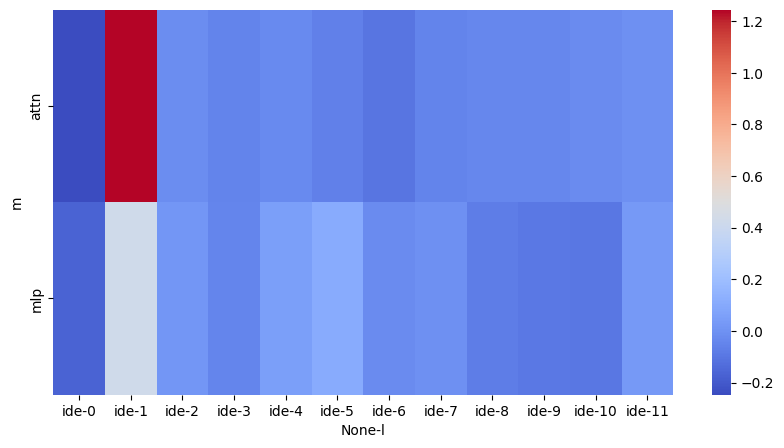

In [58]:
plt.rcParams["figure.figsize"] = (10,5)

sns.heatmap(
    df_ide.drop(['code', 'seq'], axis=1).set_index(['m', 'l']).unstack(-1),
    cmap='coolwarm'#, vmax=0.3, vmin=0, vmax=1.2, vmin=0.8
)

##### 'In popular and media culture, Anubis is often falsely portrayed as the sinister god of the dead'


<Axes: xlabel='None-l', ylabel='m'>

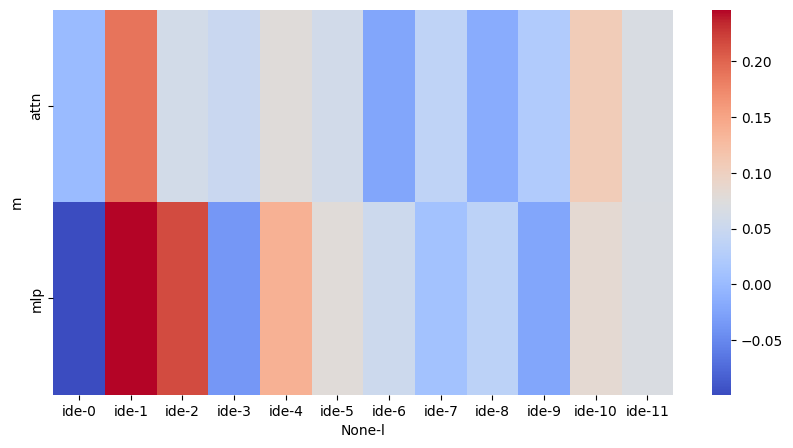

In [599]:
plt.rcParams["figure.figsize"] = (10,5)

sns.heatmap(
    df_ide.drop(['code'], axis=1).set_index(['m', 'l']).unstack(-1),
    cmap='coolwarm'#, vmax=1.2, vmin=0.8
)

##### Elderly people often have limited regenerative abilities and are more susceptible to disease, syndromes, injuries and sickness than younger adults.

<Axes: xlabel='None-l', ylabel='m'>

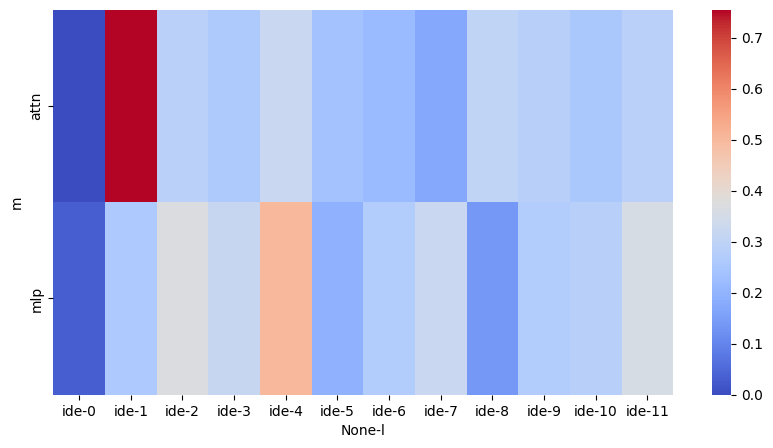

In [615]:
plt.rcParams["figure.figsize"] = (10,5)

sns.heatmap(
    df_ide.drop(['code'], axis=1).set_index(['m', 'l']).unstack(-1),
    cmap='coolwarm'#, vmax=1.2, vmin=0.8
)

##### "Zechariah's vision of recently deceased Joshua the High Priest depicts a dispute in the heavenly throne room between Satan and the Angel of the Lord"


<Axes: xlabel='None-l', ylabel='m'>

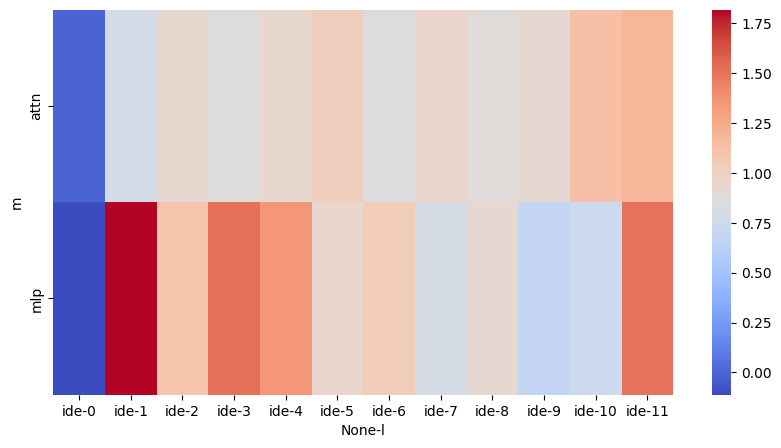

In [631]:
plt.rcParams["figure.figsize"] = (10,5)

sns.heatmap(
    df_ide.drop(['code'], axis=1).set_index(['m', 'l']).unstack(-1),
    cmap='coolwarm'#, vmax=1.2, vmin=0.8
)

##### The Transcendental Argument for the Existence of God (TAG) is the argument that attempts to prove the existence of God by arguing that logic, morals, and science ultimately presuppose a supreme being and that God must therefore be the source of logic and morals

<Axes: xlabel='None-l', ylabel='m'>

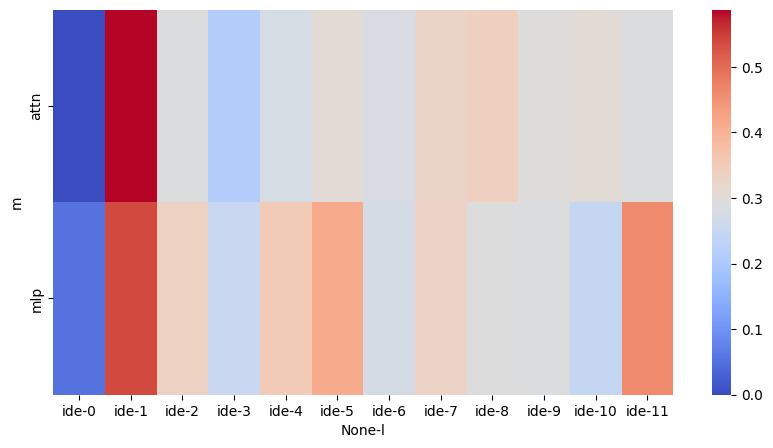

In [647]:
plt.rcParams["figure.figsize"] = (10,5)

sns.heatmap(
    df_ide.drop(['code'], axis=1).set_index(['m', 'l']).unstack(-1),
    cmap='coolwarm'#, vmax=1.2, vmin=0.8
)

## Conclusion
Couldn't find a specific pattern.  
I will extend this approach, using the entire dataset and aggregating IDE values.